<a href="https://colab.research.google.com/github/bbchen33/Insight-project/blob/master/Job_classification_based_on_descriptions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Below is a list of job titles I found to be more abundant in the data I am working with so I will use them as the labels to categorize the rest of the job titles. Original dataset is from Kaggle https://www.kaggle.com/madhab/jobposts.

In [0]:
import pandas as pd
job_posts_labeled = pd.read_csv('job_posts_labeled_all_labeled.txt', sep = '\t')

'various job' = actual job titles in the data; 'official job' = the standardardized format of a job (e.g. accountant for financial specialist or financial manager) but right now it is mostly just copy from 'various job'. The 'official job' is the label I'll give each job at the end of my training. 

I'm dropping rows with na in the 'various job' column since the actual job titles is what I want. 

In [0]:
job_posts_labeled = job_posts_labeled.dropna(subset=['various job'])

In [5]:
job_posts_labeled.head()

,various job,official job,Company,JobDescription,JobRequirment,RequiredQual
0,journalist,journalist,News.am Information-Analytic Agency,The incumbent will be responsible for agency's...,NaN,- Higher education;\r\n- Good knowledge of Eng...
1,News Editor,Editor,BlogNews.am,BlogNews.am is looking for a News Editor. He/ ...,NaN,- At least Bachelor's degree in Journalism or ...
2,HR Assistant,hr specialist,Career Center,We have a new opening for the position of HR A...,Main duties include but are not limited to the...,- Relevant graduate degree;\r\n- Fluent writte...
3,HR Assistant,hr specialist,Career Center,We have a new opening for the position of HR A...,Main duties include but are not limited to the...,- Relevant graduate degree;\r\n- Fluent writte...
4,HR Assistant,hr specialist,Career Center,We have a new opening for the position of HR A...,Main duties include but are not limited to the...,- Relevant graduate degree;\r\n- Fluent writte...


In [6]:
len(job_posts_labeled)

15090

I have found that the 'JobDescription' is most useful for getting good classification so I will only save 'various job', 'official job' and 'JobDescription' for my actual training.

In [0]:
job_posts_features = job_posts_labeled[['various job','official job','JobDescription']]

Below is a list of job titles (52) that I hand picked and decided that they were common enough to be used to categorize most of the jobs in my data set. 

In [0]:
job_titles = 'accountant, bartender, chef, chief financial officer, civil engineer, editor, research assistant, marketing specialist, salesperson, software developer, software engineer, data scientist, volunteer, lawyer, graphic designer, ceo, it specialist, project manager, product manager, technical writer, journalist, medical doctor, pharmacist, translator, qa engineer, receptionist/ administrative assistant, recruiter, hr specialist, secretary, java developer, web developer, foreign language teacher, tour guide, president, mechanical engineer, electrical engineer, driver, professor, copywriter, intern, financial analyst, general manager, procurement specialist, sales manager, insurance agent, medical representative, credit officer, database developer, deputy manager, real estate agent, data entry clerk, ai engineer'

In [9]:
job_titles = job_titles.split(', ')
len(job_titles)

52

Lowercase for all job titles so I can have a better chance of matching the 'vaious job' and 'official job'.

In [10]:
job_posts_features['official job'] = job_posts_features['official job'].str.lower()
job_posts_features['various job'] = job_posts_features['various job'].str.lower()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Finding the index where the official job is in my list of job titles so I select them for training.

In [0]:
index_list = []
for job in job_titles:
  job_index = job_posts_features[job_posts_features['official job'] == job].index
  if len(job_index) >= 15: # I restrict the data to be 15 rows or more for training
    index_list.append(job_index)

Turned out only 34 out of the 52 handpicked titles had sufficient data for training.

In [12]:
len(index_list)

35

In [13]:
index_list[:2]

[Int64Index([343, 344, 345, 346, 347, 348, 349, 350, 351, 352,
             ...
             583, 584, 585, 586, 587, 588, 589, 590, 591, 592],
            dtype='int64', length=250),
 Int64Index([  53, 2579, 2621, 2622, 2623, 2624, 2625, 2626, 2627, 2628, 2629,
             2630, 2631, 2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640,
             2641, 2642, 2643, 2644, 2645, 2646, 2647, 2648, 2649],
            dtype='int64')]

In [0]:
import numpy as np
index_combined = np.concatenate(index_list) 

In [15]:
len(index_combined)

2004

I called the ones with exactly the same labels as the handlabeled titles "labeled_df" for training my model while the rest as "unlabeled_df" to predict their "standard job titles" with my model.

In [0]:
labeled_df = job_posts_features[['various job','official job', 'JobDescription']]
labeled_df = labeled_df.iloc[index_combined]
labeled_df = labeled_df.reset_index(drop = True)

In [0]:
unlabeled_df = job_posts_features[['various job','official job', 'JobDescription']]
unlabeled_df = unlabeled_df[~unlabeled_df.index.isin(index_combined)]
unlabeled_df = unlabeled_df.reset_index(drop = True)

In [0]:
combined_df = pd.concat([labeled_df, unlabeled_df], axis = 0)
combined_df = combined_df.reset_index(drop = True)

Now the 'combined_df' is the dataframe for training a model. I'll do some text preprocessing on the job description.

In [19]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
pd.options.mode.chained_assignment = None # Turning off warning
def text_processing(text):
  stemmer = SnowballStemmer('english')
  text = re.sub(r'([0-9]+?)', '', text) 
  text = re.sub(r'  ', ' ', text)
  text = re.sub(r'   ', ' ', text)
  text = re.sub(r'(!|"|#|\$|%|&|\'|\(|\)|\*|\+|,|-|\.|/|:|;|<|=|>|\?|@|\[|\\|\]|\^|_|`|{|\||}|~)+', ' ', text)
  text = text.lower()
  text = stemmer.stem(text)
  text = text.strip()
  text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
  return ' '.join(text)

In [0]:
combined_df['JobDescription'] = combined_df['JobDescription'].apply(lambda x: text_processing(x))

In [22]:
combined_df['JobDescription'].head(3)

0    sef international growing universal credit org...
1    accountant full time national staff position b...
2    armenian forests ngo funding tufenkian foundat...
Name: JobDescription, dtype: object

Can save combined_df and just use it for training later.



In [0]:
len_for_training = len(labeled_df)

In [24]:
combined_df['official job'][:len_for_training].value_counts()

accountant                  250
medical representative      187
sales manager               143
lawyer                      123
software developer          121
project manager             102
web developer                90
java developer               87
marketing specialist         65
software engineer            65
qa engineer                  65
graphic designer             56
it specialist                48
translator                   45
driver                       43
journalist                   38
credit officer               36
foreign language teacher     35
hr specialist                34
secretary                    34
technical writer             31
chief financial officer      31
financial analyst            29
database developer           28
procurement specialist       25
intern                       24
deputy manager               23
pharmacist                   21
general manager              21
salesperson                  20
product manager              18
recruite

The distribution of each class is different so I will balance it first but before balancing, I want to vectorize the text into numbers and encode the 'official job' as 34 classes.

In [0]:
!pip install --quiet zeugma # zeugma package allows easy text embedding

In [26]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [27]:
from zeugma.embeddings import EmbeddingTransformer
word2vec = EmbeddingTransformer('word2vec') #word2vec has worked well for me. can also use glove or fasttext.

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(combined_df['official job'][:len_for_training])
combined_X = word2vec.transform(combined_df['JobDescription'])

Splitting the data into train and test before balancing so I don't oversample (duplicate) data into both train and test that will give better test accuracy than it should.

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(combined_X[:len_for_training], y, test_size = 0.3, random_state = 1)

Balancing the data with SMOTE.

In [30]:
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")
sm = SMOTE(random_state = 0)
X_res, y_res = sm.fit_resample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Making sure the classes are balanced now.

In [31]:
from collections import Counter
print('before:', sorted(Counter(y).items())[:5])
print('after:', sorted(Counter(y_res).items())[:5])

before: [(0, 250), (1, 31), (2, 15), (3, 36), (4, 28)]
after: [(0, 179), (1, 179), (2, 179), (3, 179), (4, 179)]


Perform SVC gridsearch to see how well the model can classify jobs based on job descriptions.

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
SVC_model = SVC()
param_range = np.logspace(-1, 2, 4)
param_grid = [
              {'C':param_range,
               'gamma':param_range}
]
gs = GridSearchCV(estimator = SVC_model,
                  param_grid = param_grid,
                  scoring = 'accuracy',
                  cv = 3,
                  n_jobs = -1)
gs = gs.fit(X_res, y_res)
print(gs.best_params_)


{'C': 10.0, 'gamma': 1.0}


In [0]:
clf_optimized = SVC(C = 10, gamma = 1, probability = True)

In [34]:
clf_optimized.fit(X_res, y_res)
print("The accuracy score of the optimized SVC model is: ", clf_optimized.score(X_test, y_test))

The accuracy score of the optimized SVC model is:  0.8820598006644518


In [0]:
y_prediction = clf_optimized.predict(X_test)

Since I have balanced the data, accuracy score should be sufficient to see how good the model is but I included other metrics just in case.

In [36]:
from sklearn.metrics import recall_score, precision_score, f1_score
print("Recall score: ", recall_score(y_prediction, y_test, average = 'macro'))
print("Precision score: ", precision_score(y_prediction, y_test, average = 'macro'))
print("F1 score: ", f1_score(y_prediction, y_test, average = 'macro'))

Recall score:  0.8920878160330872
Precision score:  0.8497426992188757
F1 score:  0.8612167918975658


The job prediction based on job description is 89% accurate. It's pretty good so I can use this model to classify the jobs using description. Note that the model was only trained on the jobs in the job title list. For jobs that are not similar to the ones in the list, the model is not expected to perform well. As a result, I used the model that can predict with > 60% probability to classify a job into one of the classes as the true label. Otherwise, I will just leave those out.

In [0]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_prediction)
cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]

Getting the id of the jobs that get confused easily (high misclassification rate)

In [40]:
cm_len = len(cm) 
for i in range(cm_len):
  for j in range(cm_len):
    if cm[i,j] >= 0.3 and i != j: 
      print(i,j)

10 27
28 27


In [41]:
le.inverse_transform([10,27, 28])

array(['general manager', 'sales manager', 'salesperson'], dtype=object)

In [0]:
classes = le.inverse_transform(range(cm_len))

Plotting the confusion matrix on all 34 categories I trained. General manager, sales manager and salesperson get confused the most by my model.

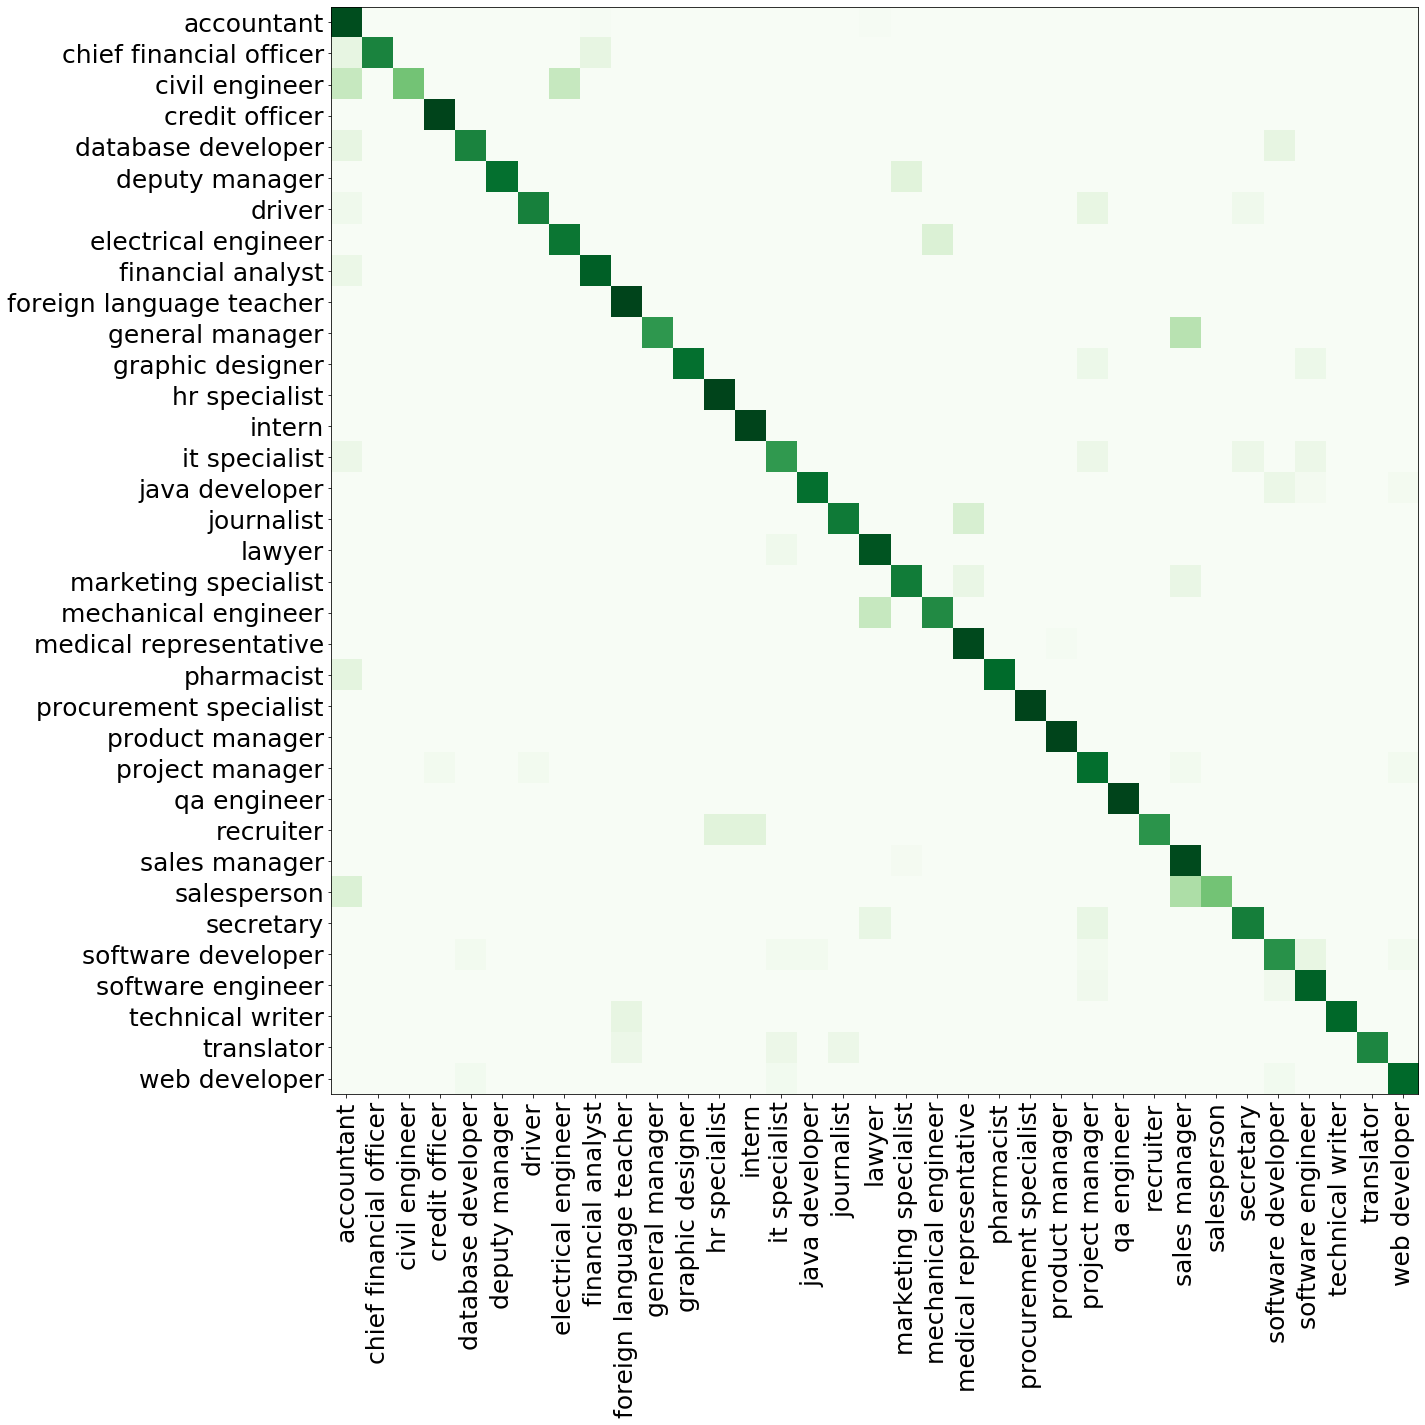

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest', cmap = 'Greens')
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation = 90)
plt.yticks(tick_marks, classes)
plt.rcParams.update({'font.size': 20})

Creating a new output table.
Giving each job a standard title if the probability is > 60% and then save these rows for a new table.

In [0]:
above_60_index = combined_df['official job'][len_for_training:][clf_optimized.predict_proba(combined_X[len_for_training:]).max(axis = 1) > 0.6].index

In [0]:
prediction = le.inverse_transform(clf_optimized.predict(combined_X[len_for_training:]))[above_60_index-len_for_training]
various_title = combined_df['various job'][above_60_index].values
job_description = combined_df['JobDescription'][above_60_index].values

In [0]:
title_output_df = pd.DataFrame(columns = ['various job', 'official job','JobDescription'])
title_output_df['various job'] = various_title
title_output_df['official job'] = prediction
title_output_df['JobDescription'] = job_description

In [48]:
title_output_df[title_output_df.duplicated(['various job'])][:6]

,various job,official job,JobDescription
17,.net c#/ c++ software developer,software developer,altacode ltd looking highly qualified motivate...
18,.net c#/ c++ software developer,software developer,altacode ltd looking highly qualified motivate...
19,.net c#/ c++ software developer,software developer,altacode ltd looking highly qualified motivate...
21,.net developer,software developer,synergy international systems inc armenia seek...
22,.net developer,java developer,responsibilities position focused software dev...
23,.net developer,web developer,net developer incumbent help build company nex...


It is not useful to have actual titles that are duplicated so I will drop them.

In [0]:
title_output_df = title_output_df.drop_duplicates(subset = ['various job'])

In [50]:
len(title_output_df)

1815

Validate the data that I've given labels to (didn't have 'official job' before) and see how robust the classification did. 

In [0]:
new_y_pred = clf_optimized.predict(combined_X[len_for_training:])

In [52]:
clf_optimized.score(combined_X[len_for_training:], new_y_pred) #100% accuracy

1.0

In [0]:
title_output_df.to_csv('title_output_Feb_5.txt', sep = '\t', index = False)

In [0]:
files.download('title_output_Feb_5.txt')